## Import required packages

In [2]:
# tested with python 3.6
import os
from collections import defaultdict
import random
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

from keras import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from keras.activations import softmax
from tensorflow.keras.utils import to_categorical
#from keras_preprocessing.sequence import pad_sequences

from keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.optimizers import Adam
import json
from tensorflow.keras import initializers 
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.layers import LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape,SpatialDropout1D
from tensorflow.keras.layers import multiply
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions


## Reading the data files

Read the annotations file for training dataset

In [3]:
annotations_train_path = r"C:\Users\patek\Downloads\hw4\abstract\annotations\abstract_v002_train2015_annotations.json"
annot_data = json.load(open(annotations_train_path))
annot_train = pd.DataFrame(annot_data["annotations"])
annot_train.head()

,question_type,multiple_choice_answer,answers,image_id,answer_type,question_id
0,who,man,"[{'answer': 'old person', 'answer_confidence':...",11779,other,117792
1,where is the,blanket,"[{'answer': 'on blanket', 'answer_confidence':...",11779,other,117790
2,where is the,bench,"[{'answer': 'on bench', 'answer_confidence': '...",11779,other,117791
3,is this,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",5536,yes/no,55360
4,what kind of,soda,"[{'answer': 'water', 'answer_confidence': 'no'...",5536,other,55361


Check the counts of different categories of answers in the annotations dataframe. 

We have selected numerical responses from a variety of categories to reduce the dataset and improve accuracy.

In [ ]:
a=pd.DataFrame(annot_train['multiple_choice_answer'].value_counts())
print(a.to_string())

Read the questions file for training dataset.

In [4]:
mcq_train_path = "C:/Users/patek\Downloads/hw4/abstract/questions/MultipleChoice_abstract_v002_train2015_questions.json"
mcq_data = json.load(open(mcq_train_path))
mcq_train = pd.DataFrame(mcq_data["questions"])
mcq_train.head()

,image_id,question,multiple_choices,question_id
0,11779,Who looks happier?,"[alive, 1, woman, purple, 2, yes, white, boy, ...",117792
1,11779,Where is the woman sitting?,"[3, no, blue, red, 1, slide, monkey bars, jump...",117790
2,11779,Where is the man sitting?,"[away, yes, blue, 1, 2, mouse, couch, no, yell...",117791
3,5536,Is this man hungry?,"[water, yellow, 4, running, blue, pouring, out...",55360
4,5536,What kind of drink is that?,"[wine, girl would fall, soda, white, yes, coke...",55361


Functions to generate file name from image_ids.

In [6]:
def append_zeros(id): # sub function to return img id padded with zeros
    arr = ["0","0","0","0","0","0","0","0","0","0","0","0"]
    count = 0
    for i in range(len(id)-1, -1,-1):
        arr[count] = id[i]
        count += 1
    return "".join(arr[::-1])
    
# Function to return the file name correponding to image id
# if type argument is passed as 't' then return will contain train file name
# else validation file name
def img_id_2_filename(image_id, type = 't'):
    img_id = str(image_id)
    if type == 't':
        file_name = "abstract_v002_train2015_"
    else:
        file_name = "abstract_v002_val2015_"
    s = append_zeros(img_id)
    return file_name + s + ".png"

Join the annotations and questions dataframe on baiss of question_id and then select columns that are required for training.

In [7]:
df_train = annot_train.merge(mcq_train, how='inner', on='question_id')
df_train = df_train[['image_id_x', 'question', 'multiple_choice_answer']]
df_train.head()

,image_id_x,question,multiple_choice_answer
0,11779,Who looks happier?,man
1,11779,Where is the woman sitting?,blanket
2,11779,Where is the man sitting?,bench
3,5536,Is this man hungry?,yes
4,5536,What kind of drink is that?,soda


Select only those questions whose output is numerical value.

In [8]:
df_dummy = pd.DataFrame(columns=['image_id_x', 'question', 'multiple_choice_answer'])
for i in range(len(df_train)):
    try:
        x = int(df_train['multiple_choice_answer'].iloc[i])
        df_dummy = df_dummy.append(df_train.iloc[i])
    except:
        continue

In [9]:
df_dummy.head()

,image_id_x,question,multiple_choice_answer
22,10005,How many pillows?,2
24,1527,How many people are in the room?,1
36,15492,How many bushes are in the background?,3
40,1329,How many logs on the grass?,2
43,14657,How many mice are crawling?,3


Added an Image_path column derived from image_id_x

In [10]:
df_dummy['Image_path'] = ""
for i in range(len(df_dummy)):
    df_dummy['Image_path'].iloc[i] = "C:/Users/patek/Downloads/hw4/abstract/images/" + img_id_2_filename(df_dummy['image_id_x'].iloc[i])

In [11]:
df_dummy.head()

,image_id_x,question,multiple_choice_answer,Image_path
22,10005,How many pillows?,2,C:/Users/patek/Downloads/hw4/abstract/images/a...
24,1527,How many people are in the room?,1,C:/Users/patek/Downloads/hw4/abstract/images/a...
36,15492,How many bushes are in the background?,3,C:/Users/patek/Downloads/hw4/abstract/images/a...
40,1329,How many logs on the grass?,2,C:/Users/patek/Downloads/hw4/abstract/images/a...
43,14657,How many mice are crawling?,3,C:/Users/patek/Downloads/hw4/abstract/images/a...


Drop the image_id_x columns as we need only image path, question and answer.

In [12]:
df_dummy.drop('image_id_x',axis=1)

,question,multiple_choice_answer,Image_path
22,How many pillows?,2,C:/Users/patek/Downloads/hw4/abstract/images/a...
24,How many people are in the room?,1,C:/Users/patek/Downloads/hw4/abstract/images/a...
36,How many bushes are in the background?,3,C:/Users/patek/Downloads/hw4/abstract/images/a...
40,How many logs on the grass?,2,C:/Users/patek/Downloads/hw4/abstract/images/a...
43,How many mice are crawling?,3,C:/Users/patek/Downloads/hw4/abstract/images/a...
...,...,...,...
59943,How many animals?,4,C:/Users/patek/Downloads/hw4/abstract/images/a...
59950,How many logs are on the fire?,2,C:/Users/patek/Downloads/hw4/abstract/images/a...
59964,How many apples fell on the ground?,3,C:/Users/patek/Downloads/hw4/abstract/images/a...
59984,How many trees are there?,0,C:/Users/patek/Downloads/hw4/abstract/images/a...


In [13]:
df_train = df_dummy

Representation of how corresponding image, question and answers can be found. 

Image path: C:/Users/patek/Downloads/hw4/abstract/images/abstract_v002_train2015_000000015616.png
Image size: (400, 700, 4)


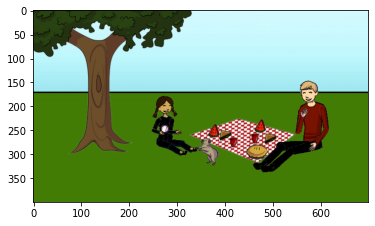

How many slices of watermelon are there?
2


In [14]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

row_no = 5 # enter row no from 0 to 59999
# this will plot the image, print a question from mcq df and answer from annot df
img_name = df_train.iloc[row_no]['Image_path']
image = Image.open(os.path.join(img_name))
print("Image path: " + img_name)
print("Image size: " + str(np.asarray(image).shape))
plt.imshow(image)
plt.show()

print(df_train.iloc[row_no]["question"])
print(df_train.iloc[row_no]["multiple_choice_answer"])


In [15]:
def read_image(image_name):
    image = Image.open(os.path.join(image_name))
    image = image.convert('RGB')  # convert images to RGB as some are in RGBA format
    my_arr = np.asarray(image.resize((224,224))) / 255.0  # resize and normalize
    return my_arr[None, :]

In [16]:
import tensorflow as tf

vgg_model = tf.keras.applications.vgg16.VGG16(weights='imagenet')
VGG16Model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [17]:
VGG16Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
row_no = 502 # enter row no from 0 to 59999
img_name = df_train.iloc[row_no]['Image_path']
image = read_image(img_name)
encoded_image = VGG16Model.predict(image)
print(encoded_image.shape)

1/1 [==============================] - 0s 418ms/step
(1, 4096)


In [19]:
file_names_train = df_train["Image_path"].drop_duplicates().values

print(file_names_train[1])

C:/Users/patek/Downloads/hw4/abstract/images/abstract_v002_train2015_000000001527.png


In [20]:
def img_generator(img_list):
    for img in img_list:
        #out_image = np.expand_dims(read_image(img), axis=0)
        out_image = read_image(img)
        yield out_image

In [125]:
enc_train = VGG16Model.predict(img_generator(file_names_train), steps=len(file_names_train), verbose=1)

7490/7490 [==============================] - 1448s 193ms/step


In [127]:
print(enc_train.shape)
np.save("encoded_images_train_VGG.npy", enc_train)

(7490, 4096)


## LSTM

In [21]:
max_len = 0
for i in df_train['question'].values:
    if len(i.split(" ")) > max_len:
        max_len = len(i.split(" "))

print(max_len)

17


In [22]:
def ques_equivate_len(ques_arr):
    ret_arr = []
    for i in range(18):
        try:
            if ques_arr[i] != " ":
                ret_arr.append(ques_arr[i])
            else:
                ret_arr.append("#")
        except:
            ret_arr.append("#")
    return ret_arr

In [23]:
# create a set of all words from questions and multiple choices 
mcq_train_questions = df_train['question'].values
mcq_train_choices = df_train['multiple_choice_answer'].drop_duplicates().values
#print(mcq_train_choices)

some_set = set()
for some_question in mcq_train_questions:
    words = some_question.lower().split(" ")
    for i in words:
        some_set.add(i)

print(len(some_set))

for ans in mcq_train_choices:
    some_set.add(ans)
print(len(some_set))

some_set.add("#")
#some_set.add(" ")
#some_set.add("w")

print(len(some_set))

some_list = list(some_set)
some_list.sort()

1454
1490
1491


In [24]:
int_to_word = {}
word_to_int = {}
for int1 in range(len(some_list)):
  word = some_list[int1]
  int_to_word[int1] = word
  word_to_int[word] = int1

In [25]:
int_to_word[1000]

'playground?'

In [26]:
word_to_int['playground?']

1000

In [27]:
answer_list = df_train['multiple_choice_answer'].drop_duplicates().values

In [28]:
def convert_to_numbers(string_arr):
    return [word_to_int[i] for i in string_arr]

def convert_to_words(num_arr):
    return [int_to_word[i] for i in num_arr]

def generator_func(ans_list=answer_list, batch_size = 128):
    bcount = 0
    ques = []
    image = []
    answer = []

    while True:
        for i in range(len(df_train)):
            img_name = df_train['Image_path'].iloc[i]
            
            ques_string = df_train['question'].iloc[i]
            ques_string = np.asarray(convert_to_numbers(ques_equivate_len(ques_string.lower().split(" "))))

            answ = df_train['multiple_choice_answer'].iloc[i]
            #print(answer_string)
            answer_string = np.zeros(38)
            #print(ans_list)
            for i in range(38):
                if ans_list[i] == answ:
                    answer_string[i] = 1
            #print(answer_string)


            #print(img_name, ques_string, answer_string)
            enc_img_ind = np.where(file_names_train == img_name)[0][0]
            enc_image = enc_train[enc_img_ind]
            ques.append(ques_string)
            image.append(enc_image)
            answer.append(answer_string)
            bcount += 1

            if bcount >= batch_size:
                yield [[np.asarray(image), np.asarray(ques)], np.asarray(answer)]
                ques = []
                image = []
                answer = []
                bcount = 0

Image Model

In [29]:
#Creating image model 
img_in = Input(shape=(4096,))
#ModelTrainingImage=Dense(1024,activation='relu',kernel_initializer=initializers.he_normal(seed=42))(img_in)
train_image=Dense(1024,activation='relu')(img_in)
train_image=Model(inputs=img_in,outputs=train_image)
train_image.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 1024)              4195328   
                                                                 
Total params: 4,195,328
Trainable params: 4,195,328
Non-trainable params: 0
_________________________________________________________________


In [30]:
vocab_len = len(word_to_int)

In [31]:
QUES_MAX_LEN = 18

#Lstm model for Questions
ques_in = Input(shape=(QUES_MAX_LEN,))
embedding1 =Embedding(vocab_len, 300, input_length=QUES_MAX_LEN,trainable=False)(ques_in)
#lst1= LSTM(64,kernel_initializer=initializers.he_normal(seed=42),kernel_regularizer=l2(0.001),return_sequences=True)(embedding1)
#lst2= LSTM(64,kernel_initializer=initializers.he_normal(seed=42),kernel_regularizer=l2(0.001),return_sequences=True)(lst1)
lone= LSTM(64,return_sequences=True)(embedding1)
ltwo= LSTM(64,return_sequences=True)(lone)
flat = Flatten(name='flatten_1')(ltwo)
ques_model=Dense(1024,activation='relu',kernel_initializer=initializers.he_normal(seed=42))(flat)
ques_model = Model(inputs=ques_in, outputs=ques_model)
ques_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 18)]              0         
                                                                 
 embedding (Embedding)       (None, 18, 300)           447300    
                                                                 
 lstm (LSTM)                 (None, 18, 64)            93440     
                                                                 
 lstm_1 (LSTM)               (None, 18, 64)            33024     
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1180672   
                                                                 
Total params: 1,754,436
Trainable params: 1,307,136
Non-tra

In [32]:
#Fusion model
fusion_model = multiply([train_image.layers[-1].output,ques_model.layers[-1].output])
dnn1 = BatchNormalization()(fusion_model)
dnn1 = Dropout(0.5)(dnn1)
dnn1 = Dense(1000,activation='relu',kernel_initializer=initializers.he_normal(seed=42))(dnn1)
CombinedOutput = Dense(38, kernel_initializer=initializers.he_normal(seed=42),activation='softmax')(dnn1)
FinalModel = Model(inputs=[img_in,ques_in], outputs=CombinedOutput)
print(FinalModel.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 18, 300)      447300      ['input_3[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 18, 64)       93440       ['embedding[0][0]']              
                                                                                                  
 lstm_1 (LSTM)                  (None, 18, 64)       33024       ['lstm[0][0]']                   
                                                                                            

In [33]:
FinalModel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 
batch_size = 128
generator = generator_func(answer_list, batch_size)
steps = len(file_names_train) * QUES_MAX_LEN // batch_size 

In [468]:
hist = FinalModel.fit(generator, steps_per_epoch=steps, epochs=5, verbose=1)

Epoch 1/5
1053/1053 [==============================] - 145s 133ms/step - loss: 0.6541 - accuracy: 0.7553
Epoch 2/5
1053/1053 [==============================] - 157s 149ms/step - loss: 0.4317 - accuracy: 0.8347
Epoch 3/5
1053/1053 [==============================] - 164s 155ms/step - loss: 0.3705 - accuracy: 0.8596
Epoch 4/5
1053/1053 [==============================] - 161s 153ms/step - loss: 0.3287 - accuracy: 0.8750
Epoch 5/5
1053/1053 [==============================] - 163s 155ms/step - loss: 0.2963 - accuracy: 0.8887


In [326]:
FinalModel.save_weights("VQA_model_weights_VGG.h5")

In [449]:
FinalModel.save_weights("VQA_model_weights_VGG_1.h5")

In [481]:
FinalModel.save_weights("VQA_model_weights_VGG_2.h5")

In [ ]:
FinalModel.load_weights("VQA_model_weights_VGG.h5")

In [34]:
FinalModel.load_weights("VQA_model_weights_VGG_2.h5")

## Decoder

In [35]:
def decode(enc_img, tokenized_ques, tokenized_choices):
    # write code
    pred = FinalModel.predict([enc_img, tokenized_ques])
    arr = []
    for i in range(38):
        arr.append(pred[0,i])
    pd_prob = pd.DataFrame({'Answer': tokenized_choices, 'Prob': arr})
    pd_prob = pd_prob.sort_values('Prob',ascending=False)
    print(pd_prob[:4].to_string(index=False))
    

In [37]:
enc_train = np.load("encoded_images_train_VGG.npy")

How many paintings?
1


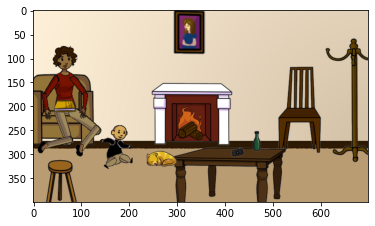

1/1 [==============================] - 1s 928ms/step
Answer         Prob
     1 9.997143e-01
     2 1.715286e-04
     3 1.141675e-04
     5 7.040336e-09


In [38]:
import tensorflow as tf

rand_ind = 500
ind_p = 0 # 0 or 1 or 2
img1 = np.asarray([enc_train[rand_ind]])
#ques_string = convert_to_numbers(ques_equivate_len(ques_string.lower().split(" ")))
print(df_train[df_train['Image_path'] == file_names_train[rand_ind]]['question'].iloc[0])
print(df_train[df_train['Image_path'] == file_names_train[rand_ind]]['multiple_choice_answer'].iloc[0])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_train[df_train['Image_path'] == file_names_train[rand_ind]]['question'].iloc[0].lower().split(" ")))])
ans = np.asarray([convert_to_numbers([df_train[df_train['Image_path'] == file_names_train[rand_ind]]['multiple_choice_answer'].iloc[0]])])

image = Image.open(os.path.join(file_names_train[rand_ind]))
plt.imshow(image)
plt.show()

decode(img1, ques, answer_list)


## Reading the validation dataset

In [39]:
annotations_val_path = r"C:\Users\patek\Downloads\hw4\abstract\annotations\abstract_v002_val2015_annotations.json"
annot_data = json.load(open(annotations_val_path))
annot_val = pd.DataFrame(annot_data["annotations"])
annot_val.head()

,question_type,multiple_choice_answer,answers,image_id,answer_type,question_id
0,is the dog,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",27578,yes/no,275780
1,what is the man,tv,"[{'answer': 'tv', 'answer_confidence': 'yes', ...",27578,other,275781
2,is the man,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",27578,yes/no,275782
3,none of the above,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",21768,yes/no,217680
4,what is,wine glass,"[{'answer': 'wine glass', 'answer_confidence':...",21768,other,217681


In [40]:
mcq_val_path = "C:/Users/patek\Downloads/hw4/abstract/questions/MultipleChoice_abstract_v002_val2015_questions.json"
mcq_data = json.load(open(mcq_val_path))
mcq_val = pd.DataFrame(mcq_data["questions"])
mcq_val.head()

,image_id,question,multiple_choices,question_id
0,27578,Is the dog asleep?,"[white, picnicking, yes, hot, dog and girl, bl...",275780
1,27578,What is the man looking at?,"[monkey bars, drinking, dog, red, blue, son, b...",275781
2,27578,Is the man sitting on the armrest?,"[2, brown, wider, sitting, yes, marriage, red,...",275782
3,21768,Did she bake the pie?,"[golden girls, sky, 1, blue, 2, 4, no, feeding...",217680
4,21768,What is resting on the table besides the pie?,"[brown, air, cumulus, no, it is playing, wine ...",217681


In [41]:
df_dummy = annot_val.merge(mcq_val, how='inner', on='question_id')
df_dummy = df_dummy[df_dummy['question_type'] == 'how many']
df_dummy = df_dummy[df_dummy['multiple_choice_answer'] != 'many']
print(df_dummy['multiple_choice_answer'].drop_duplicates().values)

['3' '2' '5' '1' '0' '4' '6' '18' '7' '16' '11' '8' '10' '14' '9' '15'
 '12' '20' '17' '21']


In [42]:
df_dummy = df_dummy[['question', 'multiple_choice_answer', 'image_id_x']]
df_dummy.head()

,question,multiple_choice_answer,image_id_x
11,How many Teacups are on the table?,3,25841
26,How many clouds?,2,29804
51,How many steps are on the sliding board?,5,26002
85,How many plants in the room?,1,28492
104,How many flowers are in the room?,0,29865


In [43]:
df_dummy['Image_path'] = ""
for i in range(len(df_dummy)):
    df_dummy['Image_path'].iloc[i] = "C:/Users/patek/Downloads/hw4/abstract/images/" + img_id_2_filename(df_dummy['image_id_x'].iloc[i],'v')

c:\Users\patek\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [44]:
df_dummy.drop('image_id_x',axis=1)

,question,multiple_choice_answer,Image_path
11,How many Teacups are on the table?,3,C:/Users/patek/Downloads/hw4/abstract/images/a...
26,How many clouds?,2,C:/Users/patek/Downloads/hw4/abstract/images/a...
51,How many steps are on the sliding board?,5,C:/Users/patek/Downloads/hw4/abstract/images/a...
85,How many plants in the room?,1,C:/Users/patek/Downloads/hw4/abstract/images/a...
104,How many flowers are in the room?,0,C:/Users/patek/Downloads/hw4/abstract/images/a...
...,...,...,...
29941,How many legs do the coaches have collectively?,8,C:/Users/patek/Downloads/hw4/abstract/images/a...
29970,How many white fabrics are in the picture?,2,C:/Users/patek/Downloads/hw4/abstract/images/a...
29982,How many bicycle re in the picture?,1,C:/Users/patek/Downloads/hw4/abstract/images/a...
29984,How many turtles are there?,2,C:/Users/patek/Downloads/hw4/abstract/images/a...


In [45]:
df_val = df_dummy

Image path: C:/Users/patek/Downloads/hw4/abstract/images/abstract_v002_val2015_000000023911.png
Image size: (400, 700, 4)


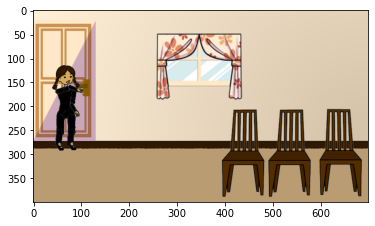

How many chairs are on the right?
3


In [46]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

row_no = 5 # enter row no from 0 to 59999
# this will plot the image, print a question from mcq df and answer from annot df
img_name = df_val.iloc[row_no]['Image_path']
image = Image.open(os.path.join(img_name))
print("Image path: " + img_name)
print("Image size: " + str(np.asarray(image).shape))
plt.imshow(image)
plt.show()

print(df_val.iloc[row_no]["question"])
print(df_val.iloc[row_no]["multiple_choice_answer"])


How many chairs are on the right?
3


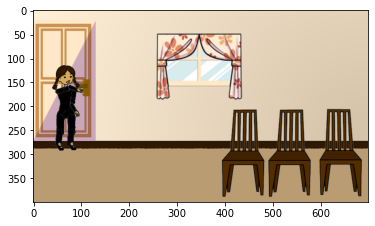

1/1 [==============================] - 0s 36ms/step
Answer     Prob
     3 0.738884
     1 0.252235
     2 0.008879
     4 0.000002


In [47]:
import tensorflow as tf

rand_ind = 5
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)


How many Teacups are on the table?
3


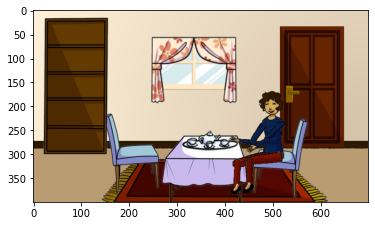

1/1 [==============================] - 0s 23ms/step
Answer     Prob
     3 0.997198
     2 0.002589
     1 0.000179
     5 0.000025


In [472]:
rand_ind = 0
df_val['question'].iloc[5]
#ques_string = convert_to_numbers(ques_equivate_len(ques_string.lower().split(" ")))
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])
#ans = np.asarray([convert_to_numbers([df_val['multiple_choice_answer'].iloc[5]])])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)


How many clouds in the sky?
3


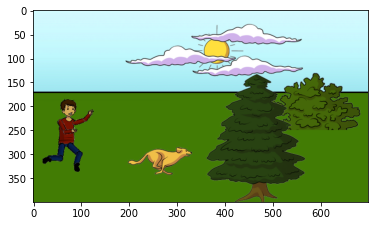

1/1 [==============================] - 0s 23ms/step
Answer     Prob
     3 0.904056
     2 0.048890
     1 0.046286
     5 0.000362


In [473]:
rand_ind = 10
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)


How many flames are in the fireplace?
1


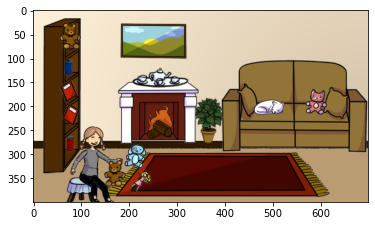

1/1 [==============================] - 0s 22ms/step
Answer     Prob
     1 0.765568
     2 0.233541
     3 0.000889
     5 0.000002


In [475]:
rand_ind = 15
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)


How many suns?
1


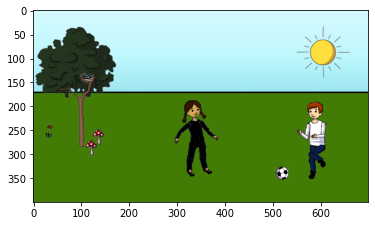

1/1 [==============================] - 0s 27ms/step
Answer         Prob
     1 9.999542e-01
     2 4.464129e-05
     3 1.165202e-06
     0 5.574016e-13


In [476]:
rand_ind = 20
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)


How many balls?
1


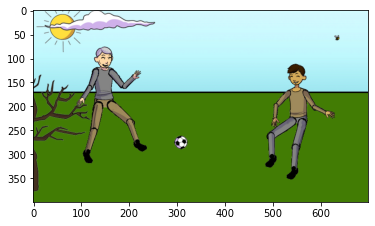

1/1 [==============================] - 0s 26ms/step
Answer         Prob
     1 9.562705e-01
     3 3.937946e-02
     2 4.349930e-03
     0 7.106563e-08


In [477]:
rand_ind = 25
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)


How many teapots do you see?
1


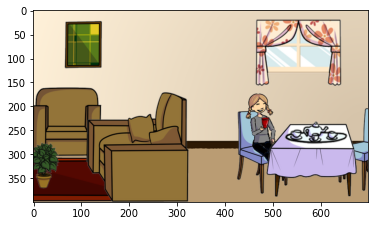

1/1 [==============================] - 0s 23ms/step
Answer     Prob
     1 0.976820
     3 0.019751
     2 0.003344
     0 0.000085


In [478]:
rand_ind = 30
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)


How many windows?
2


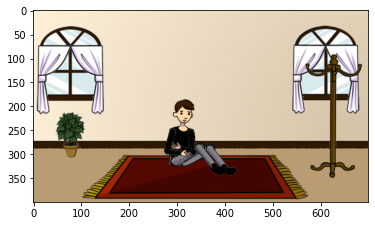

1/1 [==============================] - 0s 28ms/step
Answer         Prob
     2 5.444509e-01
     1 4.555492e-01
     3 1.012024e-08
     0 2.819592e-14


In [479]:
rand_ind = 35
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)


How many coats are on the coat rack?
0


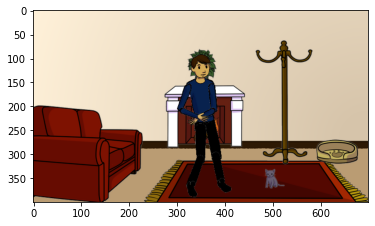

1/1 [==============================] - 0s 23ms/step
Answer         Prob
     0 1.000000e+00
     3 1.131984e-11
     1 4.659395e-14
    13 1.123400e-15


In [480]:
rand_ind = 45
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)


How many eyes does the girl on the couch have?
2


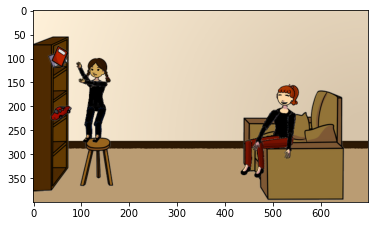

1/1 [==============================] - 0s 26ms/step
Answer         Prob
     2 9.998621e-01
     1 1.379513e-04
     3 1.745592e-08
   100 2.664812e-09


In [482]:
rand_ind = 53
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)


How many exits?
1


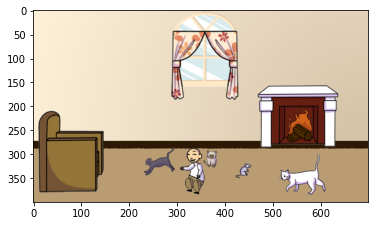

1/1 [==============================] - 0s 20ms/step
Answer         Prob
     1 9.995425e-01
     2 4.156693e-04
     3 4.188014e-05
     5 1.209849e-10


In [483]:
rand_ind = 100
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)


How many bones does the dog have?
1


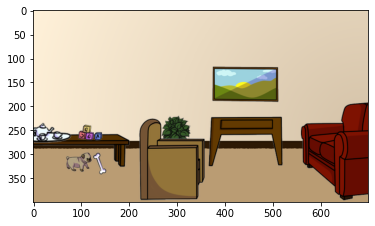

1/1 [==============================] - 0s 110ms/step
Answer     Prob
     2 0.982852
     1 0.015410
     3 0.001710
     0 0.000025


In [498]:
rand_ind = 150
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)


How many slides?
1


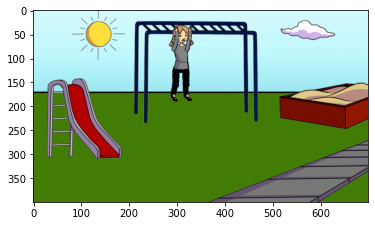

1/1 [==============================] - 0s 24ms/step
Answer         Prob
     1 9.851781e-01
     2 1.478294e-02
     3 3.899850e-05
     0 4.244011e-11


In [488]:
rand_ind = 200
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)


How many rabbits?
1


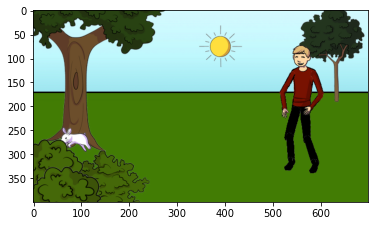

1/1 [==============================] - 0s 25ms/step
Answer         Prob
     1 9.999120e-01
     3 8.677954e-05
     2 1.045724e-06
     0 1.010709e-07


In [489]:
rand_ind = 210
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)


How many robots are there?
2


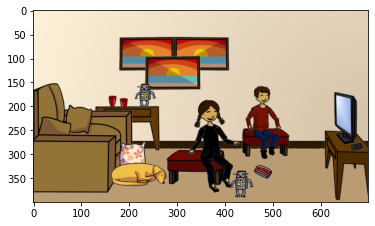

1/1 [==============================] - 0s 27ms/step
Answer     Prob
     1 0.829879
     2 0.169929
     3 0.000190
     0 0.000002


In [490]:
rand_ind = 260
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)


How many different types of bushes are there?
2


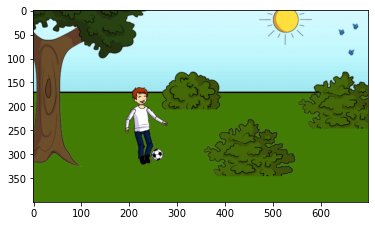

1/1 [==============================] - 0s 46ms/step
Answer         Prob
     3 9.999830e-01
     2 9.711832e-06
     1 7.404073e-06
     0 8.999800e-12
How many people is in this picture?
1


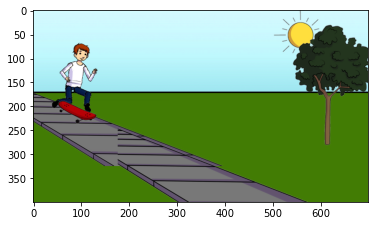

1/1 [==============================] - 0s 23ms/step
Answer     Prob
     1 0.471106
     2 0.282831
     3 0.196852
     5 0.049125
How many pets are on the couch?
3


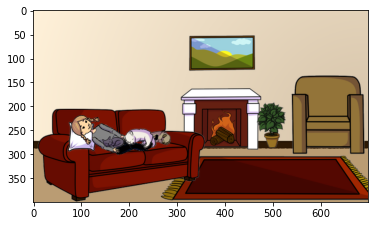

1/1 [==============================] - 0s 26ms/step
Answer     Prob
     3 0.979979
     2 0.013641
     1 0.006339
     5 0.000036
How many adults could comfortably sit on the sofa?
2


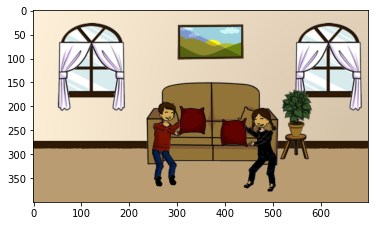

1/1 [==============================] - 0s 27ms/step
Answer         Prob
     2 9.510669e-01
     1 3.112703e-02
     3 1.780604e-02
     5 1.627491e-08
How many paintings are on the wall?
1


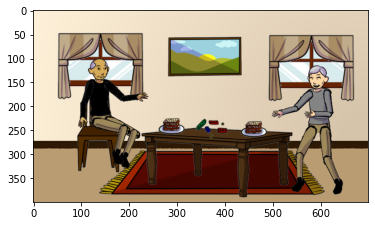

1/1 [==============================] - 0s 25ms/step
Answer     Prob
     3 0.712297
     2 0.286260
     1 0.001436
     5 0.000005
How many toys are on the shelf?
4


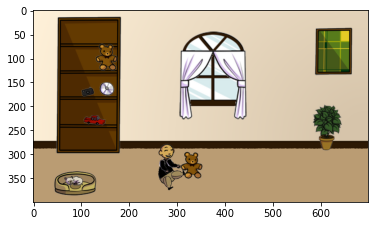

1/1 [==============================] - 0s 26ms/step
Answer     Prob
     3 0.372444
     2 0.361244
     1 0.261845
     5 0.004292
How many flowers?
6


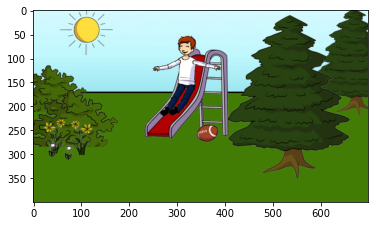

1/1 [==============================] - 0s 26ms/step
Answer     Prob
     5 0.973845
     4 0.017313
     0 0.002491
     1 0.001767
How many clouds?
3


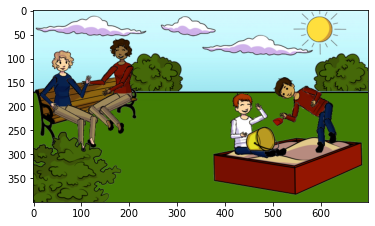

1/1 [==============================] - 0s 23ms/step
Answer         Prob
     2 6.945001e-01
     3 3.034182e-01
     1 2.081588e-03
     0 2.991119e-08
How many mushrooms can be seen?
2


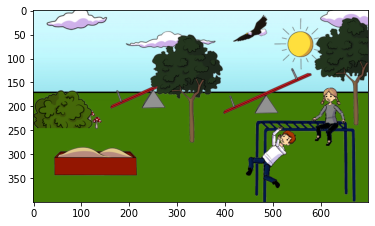

1/1 [==============================] - 0s 23ms/step
Answer     Prob
     3 0.525351
     4 0.360247
     5 0.087796
     2 0.022750
How many curtains in the picture?
2


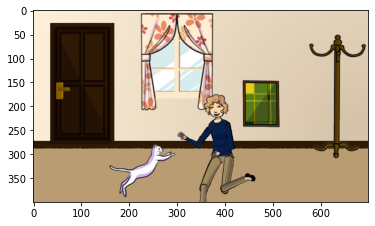

1/1 [==============================] - 0s 24ms/step
Answer     Prob
     2 0.973981
     1 0.024342
     3 0.001667
    10 0.000010
How many trees?
1


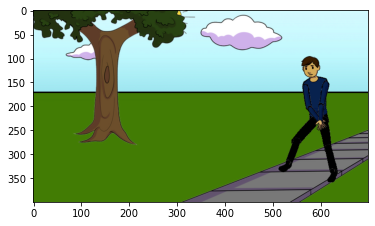

1/1 [==============================] - 0s 24ms/step
Answer         Prob
     1 9.999988e-01
     2 1.228862e-06
     3 1.861995e-09
     0 1.039742e-10


In [491]:
import tensorflow as tf

rand_ind = 250
df_val['question'].iloc[5]
#ques_string = convert_to_numbers(ques_equivate_len(ques_string.lower().split(" ")))
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])
#ans = np.asarray([convert_to_numbers([df_val['multiple_choice_answer'].iloc[5]])])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)

rand_ind = 303
df_val['question'].iloc[5]
#ques_string = convert_to_numbers(ques_equivate_len(ques_string.lower().split(" ")))
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])
#ans = np.asarray([convert_to_numbers([df_val['multiple_choice_answer'].iloc[5]])])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)

rand_ind = 310
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)

rand_ind = 315
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)

rand_ind = 320
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)

rand_ind = 325
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)

rand_ind = 330
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)

rand_ind = 436
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)

rand_ind = 445
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)

rand_ind = 553
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)

rand_ind = 500
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)


How many ducks are flying?
1


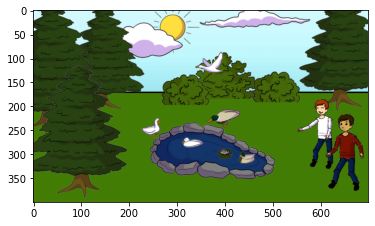

1/1 [==============================] - 0s 31ms/step
Answer     Prob
     1 0.972742
     2 0.015257
     3 0.007916
     4 0.003245
How many squirrels are there?
2


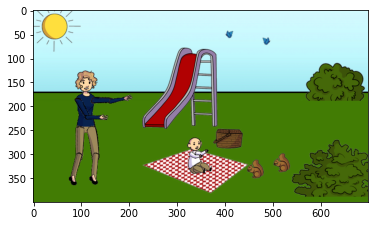

1/1 [==============================] - 0s 33ms/step
Answer     Prob
     2 0.755087
     1 0.224433
     3 0.017047
    12 0.003087
How many bottles on the blanket?
1


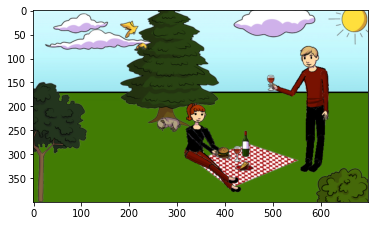

1/1 [==============================] - 0s 32ms/step
Answer     Prob
     1 0.999203
     3 0.000790
     4 0.000004
     2 0.000003
How many paintings?
2


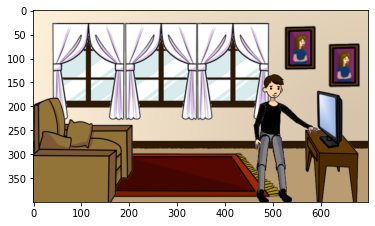

1/1 [==============================] - 0s 29ms/step
Answer     Prob
     2 0.914900
     1 0.080678
     3 0.004138
     4 0.000260


In [511]:
rand_ind = 667
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)

rand_ind = 663
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)

rand_ind = 609
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)

rand_ind = 711
df_val['question'].iloc[5]
print(df_val['question'].iloc[rand_ind])
print(df_val['multiple_choice_answer'].iloc[rand_ind])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_val['question'].iloc[rand_ind].lower().split(" ")))])

img_name = df_val.iloc[rand_ind]['Image_path']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()

img_name = df_val.iloc[rand_ind]['Image_path']
image = read_image(img_name)
img1 = VGG16Model.predict(image)

decode(img1, ques, answer_list)

## HeatMap for image

In [56]:
model1 = InceptionV3(weights='imagenet')
model1.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 149, 149, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_189 (Batch  (None, 149, 149, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                      

In [54]:
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
import cv2

1/1 [==============================] - 0s 203ms/step


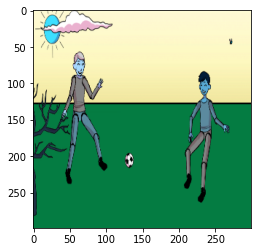

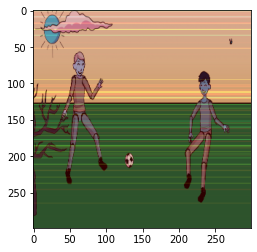

In [62]:
def ImageHeatmaps(images, intensity=0.5, res=299):
  images_ = image.load_img(images, target_size=(299, 299))
  val = image.img_to_array(images_)
  valx = np.expand_dims(val, axis=0)
  valx = preprocess_input(valx)
  predcted_Values = model1.predict(valx)
  with tf.GradientTape() as gradValue:
    ConvLastLayer = model1.get_layer('conv2d_200')
    dataiter = tf.keras.models.Model([model1.inputs], [model1.output, ConvLastLayer.output])
    OutModel, ConvLastLayer = dataiter(valx)
    OutClass = OutModel[:, np.argmax(OutModel[0])]
    Gradient = gradValue.gradient(OutClass, ConvLastLayer)
    pooled_Gradient = K.mean(Gradient, axis=(0, 1, 2))
  ImageHeatmaps = tf.reduce_mean(tf.multiply(pooled_Gradient, ConvLastLayer), axis=-1)
  ImageHeatmaps = np.maximum(ImageHeatmaps, 0)
  ImageHeatmaps /= np.max(ImageHeatmaps)
  ImageHeatmaps = ImageHeatmaps.reshape((1,35,35)).flatten()
  img = cv2.imread(images)
  ImageHeatmaps = cv2.resize(ImageHeatmaps, (img.shape[1], img.shape[0]))
  ImageHeatmaps = cv2.applyColorMap(np.uint8(255*ImageHeatmaps), cv2.COLORMAP_JET)
  img = ImageHeatmaps * intensity + img
  y = cv2.resize(cv2.imread(images), (res, res))
  y = cv2.normalize(y, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  plt.imshow(y)
  plt.show()
  x = cv2.resize(img, (res, res))
  x = cv2.normalize(x, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  #print(x)
  plt.imshow(x)
  plt.show()
  cv2.imshow('', cv2.resize(cv2.imread(images), (res, res)))
  #cv2.waitKey()
  cv2.imshow('', cv2.resize(img, (res, res)))
  #cv2.waitKey()

#for i in range(5):
ImageHeatmaps(df_val['Image_path'].iloc[25])

## Attention map

In [63]:
import seaborn as sns

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [149]:
def AM(similarity, str_arr, cmap = "RdPu"):
  DataFrame = pd.DataFrame(similarity)
  DataFrame.columns = str_arr
  DataFrame.index = str_arr
  fig, ax = plt.subplots(figsize=(8,5))
  sns.heatmap(DataFrame, cmap=cmap)

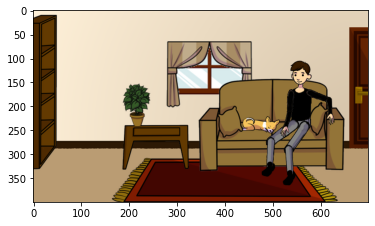

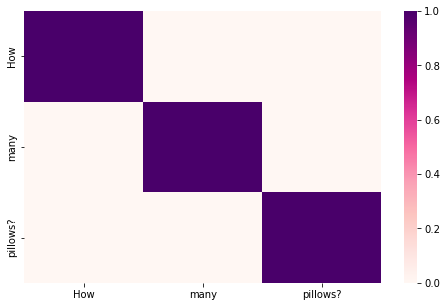

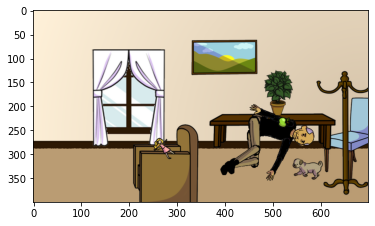

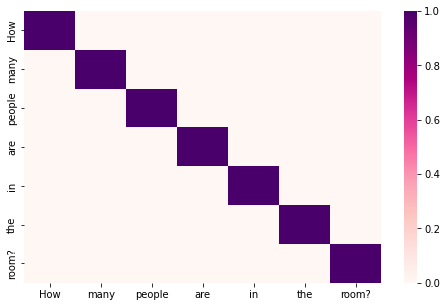

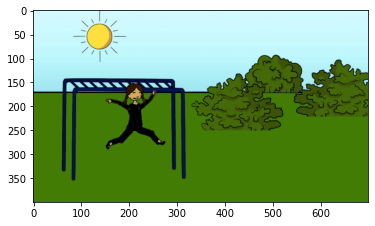

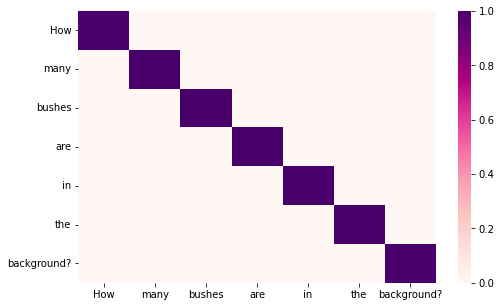

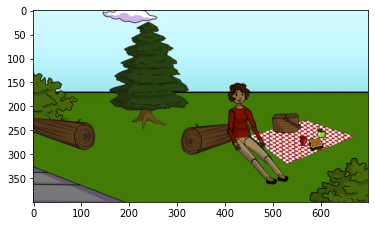

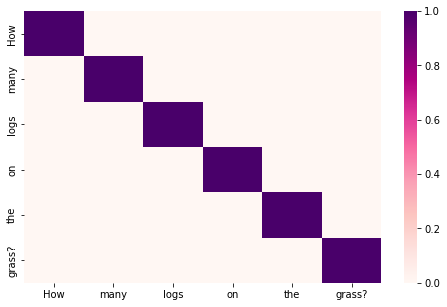

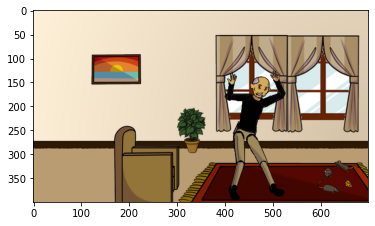

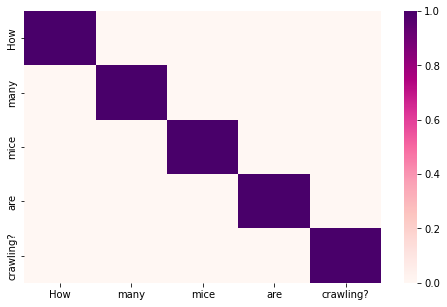

: 

In [150]:
for i in range(5):
  string_txt=df_train['question'].iloc[i].split()
  str_arr = [headline[:20] for headline in string_txt]
  vect = CountVectorizer().fit_transform(string_txt)
  arr = vect.toarray()
  image = cv2.cvtColor(cv2.imread(df_train['Image_path'].iloc[i]), cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  AM(cosine_similarity(arr), str_arr)
  plt.show()